# **FaceNet_TF-2.0**

#### The github repo corresponding to this notebook : [FaceNet_TF-2.0](https://github.com/Ashish013/FaceNet_TF-2.0)








####**To train, make sure train images are in a folder named data in Google Drive**




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2,dlib,shutil
from glob import glob
from PIL import Image
import os,sys,gdown
from zipfile import ZipFile
from tensorflow.keras.layers import Dense,Input,Flatten,Lambda
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
import warnings
warnings.filterwarnings('ignore')
 
#shutil.copyfile('/content/drive/My Drive/Colab Notebooks/pca_plotter.py','/content/pca_plotter.py')
#from pca_plotter import PCAPlotter
 
directory = '/content/drive/My Drive/Colab Notebooks/data/'
plt.rcParams['figure.figsize'] = (10,10)

In [ ]:
paths = glob(directory+'*')
face_names = [i.split('/')[-1] for i in paths]

In [ ]:
# initializing parameters

emb_size = 128
img_size = 200
margin = 0.4
minimum = 1e+3

# calculates the min. no of images from all classes
for i in paths:
  temp = len(glob(f'{i}/*'))
  if temp < minimum:
    minimum = temp
  print(i.split('/')[-1],temp)

imgs_per_folder = minimum
total_imgs = len(paths)*imgs_per_folder
batch_size = (imgs_per_folder*len(paths))

Srinadh 23
Usha 37
Ashish 74
Anish 46


In [ ]:
def remove_undetected(directory = directory,detector ='hog'):

  '''Removes the undetected images in data'''

  all_imgs = glob(f'{directory}*/*')

  for img in all_imgs:
    arr_img = np.asarray(Image.open(img))
    try:
      faces_detected = face_detector(arr_img,detector)
    except:
      print(img)
      os.remove(img)
      continue
  
    if (faces_detected == None) or (faces_detected == []):
      print(img)
      os.remove(img)

In [ ]:
def face_detector(img,detector = 'hog'):

  if detector.lower() == 'hog':

    hogFaceDetector = dlib.get_frontal_face_detector()
    faceRects = hogFaceDetector(img, 1)
    faceRect = faceRects[0]
    if faceRect.top() > 0 and faceRect.bottom() > 0 and faceRect.left() > 0 and faceRect.right() > 0:
      return  faceRect.top(), faceRect.bottom(), faceRect.left(), faceRect.right()
    else:
      return None

  elif detector.lower() == 'cnn':

    dnnFaceDetector = dlib.cnn_face_detection_model_v1('./dlib-models/mmod_human_face_detector.dat')
    rects = dnnFaceDetector(img, 1)
    faceRect  = rects[0]
    if faceRect.rect.top() > 0 and faceRect.rect.bottom() > 0 and faceRect.rect.left() > 0 and faceRect.rect.right() > 0:
      return faceRect.rect.top(),faceRect.rect.bottom(),faceRect.rect.left(),faceRect.rect.right()
    else:
      return None

In [ ]:
def make_data_array(directory = directory,detector = 'Hog',img_size = img_size,imgs_per_folder = imgs_per_folder,check_detection = True,total_imgs = total_imgs):
  
  '''Loads the data from disk to an array to speed up during training'''

  data = np.zeros((total_imgs,img_size,img_size,3),dtype = np.int)
  y = np.zeros((total_imgs))
 
  if check_detection:
    print("Removing undetected Images")
    remove_undetected(directory,detector)
    print("Removed undetected Images")
    print('-----------------------------------------\n')
  else:
    print("Skipping Detection Check")
    print('-----------------------------------------')
  print("Detecting Faces")

  if detector.lower() == 'cnn' :
    ! git clone https://github.com/davisking/dlib-models.git
    !bunzip2 "./dlib-models/mmod_human_face_detector.dat.bz2"
 
  for index1,individual in enumerate(paths):
    for index2,picture in enumerate(glob(f'{individual}/*')[:imgs_per_folder]):
      img = np.asarray(Image.open(picture))
 
      y1,y2,x1,x2 = face_detector(img,detector)
      resized_img = cv2.resize(img[y1:y2,x1:x2],(img_size,img_size))
    
      #data_emb[index1*imgs_per_folder+index2,:] = emb_model(np.expand_dims(resized_img,axis = 0))
      data[index1*imgs_per_folder+index2] = resized_img 
      y[index1*imgs_per_folder+index2] = index1
  
  print("Faces Detected and Loaded Successfully")
  return data,y
  

In [ ]:
data,y_names = make_data_array(directory,detector = 'Hog',check_detection = False)

Skipping Detection Check
-----------------------------------------
Detecting Faces
Faces Detected and Loaded Successfully


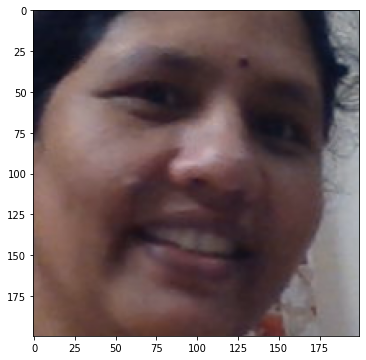

In [ ]:
plt.imshow(data[np.random.choice(range(data.shape[0]))])

In [ ]:
def positive_anchor_mask(y_inputs):

  equals_positive = tf.equal(tf.expand_dims(y_inputs,0),tf.expand_dims(y_inputs,1))
  indices_not_equals = tf.logical_not(tf.cast(tf.eye(tf.shape(y_inputs)[0]),tf.bool))
  anchor_positive_mask = tf.logical_and(equals_positive,indices_not_equals)

  return anchor_positive_mask

In [ ]:
def negative_anchor_mask(y_inputs):
  
  negative_anchor_mask = tf.logical_not(tf.equal(tf.expand_dims(y_inputs,0),tf.expand_dims(y_inputs,1)))
  return negative_anchor_mask

In [ ]:
class Online_Mining(tf.keras.layers.Layer):

    def __init__(self,margin = 0.6):
        super(Online_Mining, self).__init__()
        self.margin = margin

    def call(self, total_input):
        
        self.inputs,y_inputs = total_input
        self.y_inputs = tf.reshape(y_inputs,[y_inputs.shape[0],])

        dot_product = tf.matmul(self.inputs, tf.transpose(self.inputs))
        square_norm = tf.linalg.diag_part(dot_product)
        distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)
        pairwise_dist = tf.maximum(distances,0.0)

        mask_anchor_positive = tf.cast(positive_anchor_mask(self.y_inputs),tf.float32)
        anchor_positive_dist = tf.multiply(pairwise_dist,mask_anchor_positive)
        hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)

        mask_anchor_negative = tf.cast(negative_anchor_mask(self.y_inputs),tf.float32)
        anchor_negative_dist_max = tf.reduce_max(pairwise_dist,axis = 1,keepdims=True)
        anchor_negative_dist = pairwise_dist + tf.multiply(anchor_negative_dist_max,(1.0 - mask_anchor_negative))
        hardest_negative_dist = tf.reduce_min(anchor_negative_dist,axis = 1, keepdims = True )

        loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + self.margin, 0.0)
        loss = tf.reduce_mean(loss)

        return loss

In [ ]:
class ScaleLayer(tf.keras.layers.Layer):
  def __init__(self):
    super(ScaleLayer, self).__init__()

  def call(self, inputs):
    return tf.math.sqrt(tf.maximum(inputs,0.0), name ='Square_root')

In [ ]:
# Initializes the embedding model and pre trained weights
ptm = ResNet50(input_shape =(img_size,img_size,3), include_top=False,weights=None)
x = Flatten()(ptm.output)
x = Dense(emb_size,activation = 'softmax')(x)
x = ScaleLayer()(x)
emb_model = Model(ptm.input,x)

print("Downloading weights......")
gdown.download('https://drive.google.com/uc?export=download&confirm=tOfl&id=1NYd6cQlewoQiFH71BHeOy2eTsZEvGzLg',output = './pretrained.zip',quiet = False)
print("pretrained weights Downloaded !!")

with ZipFile("./pretrained.zip", 'r') as zip:
  zip.extractall(path = '/content/')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=tOfl&id=1NYd6cQlewoQiFH71BHeOy2eTsZEvGzLg
To: /content/pretrained.zip
135MB [00:00, 174MB/s] 


pretrained weights Downloaded !!


In [ ]:
emb_model.load_weights('./pretrained/ptm_weights')

In [ ]:
input = Input(shape = (img_size,img_size,3))
input1 = Input(shape = (1),batch_size = batch_size)
x = emb_model(input)
x = Online_Mining(margin)([x,input1])
model = Model(inputs = [input,input1], outputs = x)

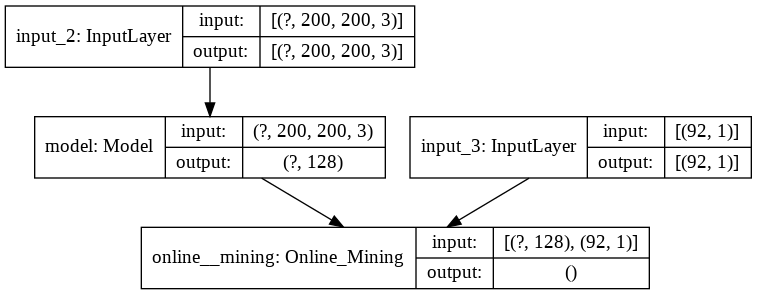

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

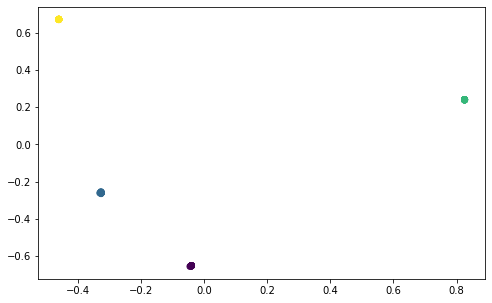

In [ ]:
from sklearn.decomposition import PCA
pca_out = PCA(n_components=2).fit_transform(emb_model(data))
plt.figure(figsize=(8, 5))
plt.scatter(pca_out[:, 0], pca_out[:, 1], c = y_names)

In [ ]:
train_gen = ImageDataGenerator(brightness_range = (0.4,1.8),zca_whitening=True,horizontal_flip = True)
train_generator = train_gen.flow(x = data, y = y_names, batch_size = batch_size,shuffle = True)
def train(batch_size=batch_size):
  while True:
    yield next(train_generator),np.zeros((batch_size))

In [ ]:
def custom_loss(y_true,y_pred):
  return y_pred

In [ ]:
epochs = 20
steps_per_epoch = np.ceil(int(total_imgs/batch_size)) * 4
model.compile(loss = custom_loss, optimizer= tf.keras.optimizers.Adam(9e-6))

In [ ]:
r = model.fit(train(batch_size),steps_per_epoch = steps_per_epoch ,epochs= epochs)

Epoch 1/20
4/4 [==============================] - 2s 613ms/step - loss: 0.7459
Epoch 2/20
4/4 [==============================] - 2s 622ms/step - loss: 0.2358
Epoch 3/20
4/4 [==============================] - 3s 628ms/step - loss: 0.0826
Epoch 4/20
4/4 [==============================] - 2s 601ms/step - loss: 0.0017
Epoch 5/20
4/4 [==============================] - 2s 594ms/step - loss: 0.0000e+00
Epoch 6/20
4/4 [==============================] - 2s 596ms/step - loss: 0.0000e+00
Epoch 7/20
4/4 [==============================] - 2s 601ms/step - loss: 0.0000e+00
Epoch 8/20
4/4 [==============================] - 2s 603ms/step - loss: 0.0000e+00
Epoch 9/20
4/4 [==============================] - 2s 607ms/step - loss: 0.0000e+00
Epoch 10/20
4/4 [==============================] - 2s 611ms/step - loss: 0.0000e+00
Epoch 11/20
4/4 [==============================] - 2s 608ms/step - loss: 0.0000e+00
Epoch 12/20
4/4 [==============================] - 2s 604ms/step - loss: 0.0000e+00
Epoch 13/20
4/4 [

In [ ]:
emb_model.save_weights('/content/drive/My Drive/Colab Notebooks/trained/trained_weights')

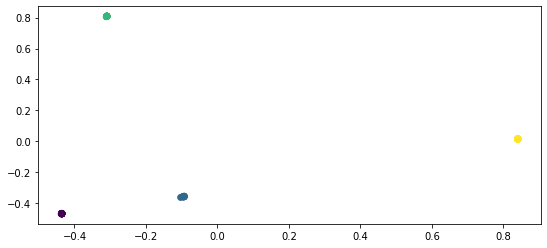

In [ ]:
from sklearn.decomposition import PCA
pca_out = PCA(n_components=2).fit_transform(emb_model(data))
plt.figure(figsize=(9, 4))
plt.scatter(pca_out[:, 0], pca_out[:, 1], c = y_names)

### Evaluate Mode

In [ ]:
faces = np.zeros((len(paths),emb_size))
pred = emb_model(data)
for num_person in range(len(paths)):
  print(face_names[num_person])
  index_start = num_person * imgs_per_folder
  index_end = (num_person+1) * imgs_per_folder
  median_embedding = np.median(pred[ index_start : index_end],axis = 0)
  faces[num_person] = median_embedding

#np.save('/content/drive/My Drive/Colab Notebooks/faces_emb_reference',faces)
np.save('/content/faces_emb_reference',faces)

Srinadh
Usha
Ashish
Anish


In [ ]:
with open('./names_reference.txt','w') as face_txt:
  for name in face_names:
    face_txt.writelines(name + ' ')
with open('./names_reference.txt','r') as face_txt:
  trial = face_txt.readline().split()

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


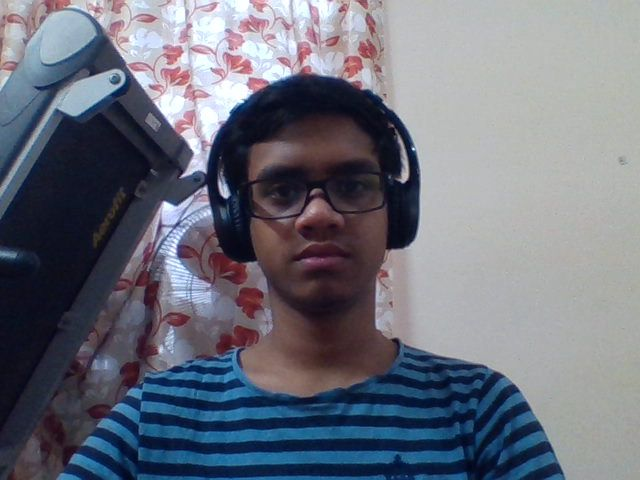

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

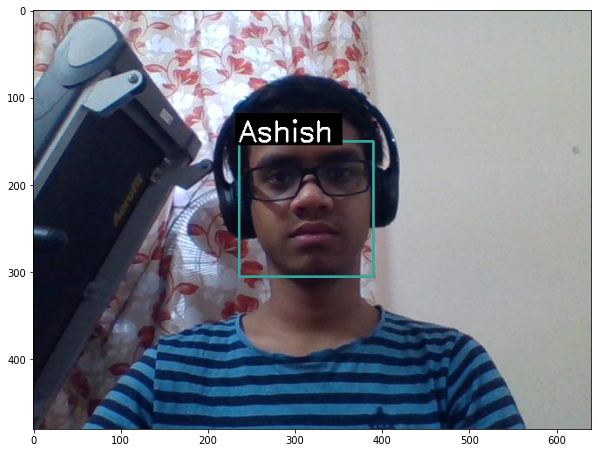

In [ ]:
from PIL import Image

arr_pic = np.asarray(Image.open('./photo.jpg'))
y1,y2,x1,x2 = face_detector(arr_pic,'hog')
arr_pic_crop = cv2.resize(arr_pic[y1:y2,x1:x2],(img_size,img_size))
original = emb_model(np.expand_dims(arr_pic_crop,0))

try:
   squared_dist = tf.reduce_sum(tf.square(original - faces),axis = 1)
   if np.min(squared_dist) < 0.6:
    detection = face_names[np.argmin(squared_dist)]
   else:
    detection = 'Not Found'
    
except:
  detection = 'Not Found'

fontsize = 1.1
cv2.rectangle(arr_pic,(x1,y1),(x2,y2),(53,167,156),2)
(text_width, text_height) = cv2.getTextSize(detection,cv2.FONT_HERSHEY_SIMPLEX,fontScale = fontsize,thickness = 2)[0]
cv2.rectangle(arr_pic,(x1-4,y1+4),(x1+text_width+8,y1-text_height-8),(0,0,0),cv2.FILLED)
cv2.putText(arr_pic,detection,(x1,y1),cv2.FONT_HERSHEY_SIMPLEX,fontsize,(255,255,255),2)
plt.figure(figsize = (15,15))
plt.imshow(arr_pic)

In [ ]:
callbacks=[PCAPlotter(plt,emb_model,data,y_names)])

In [ ]:
def positive_anchor_mask(total_shape):
  mask = np.zeros((total_shape,total_shape),np.bool)

  for i in [imgs_per_folder*i for i in range(len(paths))]:
    mask[i:i+imgs_per_folder,i:i+imgs_per_folder] = True
  for i in range(total_shape):
    mask[i,i] = False

  return mask

def negative_anchor_mask(total_shape):
  mask = np.ones((total_shape,total_shape),dtype = np.bool)

  for i in [imgs_per_folder*i for i in range(len(paths))]:
    mask[i:i+imgs_per_folder,i:i+imgs_per_folder] = False

  return mask

In [ ]:
def online_mining(data,y_input):

  dot_product = tf.matmul(data, tf.transpose(data))
  square_norm = tf.linalg.diag_part(dot_product)
  distances  = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)
  pairwise_dist = tf.maximum(distances,0.0)
  
  
  mask_anchor_positive = tf.cast(positive_anchor_mask(y_input),tf.float32)
  anchor_positive_dist = tf.multiply(pairwise_dist,mask_anchor_positive)
  hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)


  mask_anchor_negative = tf.cast(negative_anchor_mask(y_input),tf.float32)
  anchor_negative_dist_max = tf.reduce_max(pairwise_dist,axis = 1,keepdims=True)
  anchor_negative_dist = pairwise_dist + tf.multiply(anchor_negative_dist_max,(1.0 - mask_anchor_negative))
  hardest_negative_dist = tf.reduce_min(anchor_negative_dist,axis = 1, keepdims = True )


  margin = 0.6
  loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)
  loss = tf.reduce_mean(loss)
  return loss